In [462]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import numpy as np
import random
import operator as op
from functools import reduce
from tqdm import tqdm
import copy
import pickle
from scipy import io
import networkx as nx

In [463]:
A_T= np.zeros((50, 50), dtype=float)
A_T[1::2, ::2] = 1
A_T[::2, 1::2] = 1
A_T_ORG=A_T
np.save('AT',A_T)

In [464]:
#The purpose of this partitioning appears to be part of the Metropolis-Hastings algorithm.
# The binomial coefficien: C(n, r) = n! / (r! * (n - r)!)
def ncr(n, r):  #n choose r
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

def index_2d(myList, v): #return the exact index
    for i, x in enumerate(myList):
        if v in x:
            return (i, x.index(v))

def l_ij(alpha,beta, A_T,part):       #number of links between group i and j
    link_num = 0
    for a in part[alpha]:
        for b in part[beta]:
            if A_T[a, b] == 1:
                link_num += 1
    return(link_num)


def r_ij(alpha,beta, part):       #maximum possible number of links between group i and j
    return(len(part[alpha]) * len(part[beta]))

In [465]:
def R(i, j, A_T, all_part):   #all_part is a list containing all different partitions
    big_sum= 0
    Z=0
    first_loop_cond = True
    for part in all_part:

        if first_loop_cond:
            gooz_list = [[x,y] for x in range(len(part)) for y in range(len(part)) if len(part[x])<len(part[y])]
            pair_list=[]
            for x in gooz_list:
                if x not in pair_list: pair_list.append(x)

            # H(p) formula
            H_P = 0
            for pair in pair_list:
                alpha, beta = pair
                l = l_ij(alpha, beta, A_T, part)
                r = r_ij(alpha, beta, part)
                h_p = math.log(r+1) + math.log(ncr(r, l))
                H_P += h_p

            Z += np.exp(-H_P)
            first_loop_cond = False
        # print('Pair:',pair,',l:',l,',r:',r,',h_p:',h_p,',H_P:',H_P)


        # define : (l(sigma_i,sigma_j) + 1) / (r(sigma_i,sigma_j) + 2) inside R formula
        sigma_i = index_2d(part, i)[0]
        sigma_j = index_2d(part, j)[0]
        l = l_ij(sigma_i , sigma_j , A_T, part)
        r = r_ij(sigma_i , sigma_j , part)
        parantez = ((l + 1)/(r+2))

        # print(Z)
        big_sum += parantez* np.exp(-H_P)
        R_ij = big_sum/Z
        # print('reliability of i={} and j={}:'.format(i, j), round(R_ij,4))
    return(round(R_ij,5))





In [466]:
# I also define H(P) seperatly because I need it in metropolis function
def H(P,AT_tmp):
    pair_list=[]
    H_P=0
    for i in range(len(P)):
        for j in range(len(P)):
            if i<=j:
                pair_list.append([i,j])
    for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, AT_tmp, P)
            r = r_ij(alpha, beta, P)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
    return(H_P)

In [467]:
def Metropolis(T,ens,AT_tmp):#number of iterations (ensemble size)
    e=[] #store result of simulation
    for i in tqdm(range(ens)):
        partitions =  [[i] for i in range(AT_tmp.shape[0])].copy()
        c=0
        for kk in range(T):
            partitions = [ele for ele in partitions if ele != []]
            part_before=copy.deepcopy(partitions)

            H0=H(partitions,AT_tmp) #compute hamiltonian
            rpp=random.randint(0,len(partitions)-1)
            m,n=index_2d(partitions,rpp)
            a=partitions[m][n] #select random partition from rpp
            del partitions[m][n] #delete an element at a specific position in a 2D list
            rp=random.randint(0,len(partitions)-1)
            partitions[rp].append(a) #moves (a) to another random partition rp
            Hf=H(partitions,AT_tmp)
            deltaH=Hf-H0 #calculates the change in energy due to move
            if deltaH>0:
                if random.random() > np.exp(-deltaH):
                    partitions=part_before.copy()
        ppp = [ele for ele in partitions if ele != []]
        e.append(ppp)
        #     partitions = [ele for ele in partitions if ele != []]
        #
        # ppp=copy.deepcopy(partitions)
        # e.append(ppp) # The final partitioning is appended to the e list
        print(H(partitions,AT_tmp))
        print(kk)
    return(e)

In [468]:
es = Metropolis(100, 20,A_T)

 10%|█         | 2/20 [00:00<00:03,  5.76it/s]

487.32679164275913
99
467.9938038900498
99


 20%|██        | 4/20 [00:00<00:02,  5.47it/s]

558.3867397216452
99
529.3439382255905
99


 30%|███       | 6/20 [00:01<00:02,  5.27it/s]

486.0401974081867
99
465.9098543159633
99


 35%|███▌      | 7/20 [00:01<00:02,  5.40it/s]

531.780938522026
99


 45%|████▌     | 9/20 [00:01<00:02,  5.16it/s]

544.6982022957426
99
540.2334355839595
99


 55%|█████▌    | 11/20 [00:02<00:01,  5.25it/s]

506.29961550947024
99
541.6608237921636
99


 65%|██████▌   | 13/20 [00:02<00:01,  5.47it/s]

479.3166026235022
99
487.326791642759
99


 75%|███████▌  | 15/20 [00:02<00:00,  5.47it/s]

508.4314655778601
99
507.6248017453245
99


 85%|████████▌ | 17/20 [00:03<00:00,  5.50it/s]

445.0710556447687
99
562.9583879494799
99


 95%|█████████▌| 19/20 [00:03<00:00,  5.47it/s]

557.040897275919
99
466.0125848349199
99


100%|██████████| 20/20 [00:03<00:00,  5.40it/s]

466.0335391069625
99


In [469]:
def link_remover(A_T, ratio): #adjacency matrix :A_T #the ratio of links to be removed:ratio
    one_index = np.where(A_T==1)
    one_list = [[one_index[0][i], one_index[1][i]] for i in range(len(one_index[0]))]
    r = random.sample(one_list, int(ratio * np.sum(A_T)/2)) #randomly selects a subset of the pairs
    return(r)

#sorting
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li.reverse()

#extract the first element
def Extract(lst):
    return list(list(zip(*lst))[0])

def acc(k):
    zeros=k.count(0)
    ones=k.count(1)
    ef=0
    for i in range(len(k)):
        if k[i]==1:
            ef+=k[i:].count(0)/zeros
    return ef/ones

We are computing the reliability of links that were originally set to zero in the adjacency matrix A_T. The code we've provided iterates through the zero entries in the adjacency matrix and calculates the reliability using the R function.

In [470]:
zero_real = []
zero_index = np.where(A_T==0)

for i in tqdm(range(len(zero_index[0]))):
    #computed reliability for each link is appended to the zero_real list
    zero_real.append(R(zero_index[0][i], zero_index[1][i], A_T, es))

100%|██████████| 1250/1250 [00:01<00:00, 1114.32it/s]


In [471]:
rat=np.linspace(0.1,1,10) #removal ratio
accs=[]
for r in rat:
    A_T_ORG=A_T
    selected_links = link_remover(A_T, r) #select links to remove from the adjacency matrix (based on ratio)
    #Set the selected links to 0 in the adjacency matrix to simulate link removal.
    #print(selected_links)
    for link in selected_links: A_T[link[0], link[1]] = 0 #index 0 and index 1
    #Calculate the reliability of the removed links using the R function and store these values in the zero_fake list.
    zero_fake=[]
    for i in selected_links:
        zero_fake.append(R(i[0], i[1], A_T, es))
    #Print the mean value of the reliabilities of the removed links
    print('the mean value', round(np.mean(zero_fake),2))
    #aggregate all the reliabilities (both real and removed)
    all_real = []
    for i in zero_fake: all_real.append([1, i])
    for i in zero_real: all_real.append([0, i])
    #print(all_real)
    Sort(all_real)
    #print(all_real)
    #print('..............................')
    ext=Extract(all_real)
    #print(ext)
    #calculate the accuracy of the network based on the sorted reliabilities
    accs.append(acc(ext))

the mean value 12.94
the mean value 11.94
the mean value 10.73
the mean value 9.17
the mean value 7.72
the mean value 6.42
the mean value 5.27
the mean value 4.52
the mean value 3.92
the mean value 3.67


#### CONCLUSION:
This information helps us to understand how network reliability changes as we remove links.
Based on these results, it appears that as we remove more links, the mean reliability of the removed links decreases. This is an expected outcome, as removing links reduces the network's overall connectivity and makes it less reliable in terms of link connectivity. The decreasing trend in mean reliability suggests that removing more links has a more significant impact on network reliability.

Text(0.5, 1.0, 'Missing intractions')

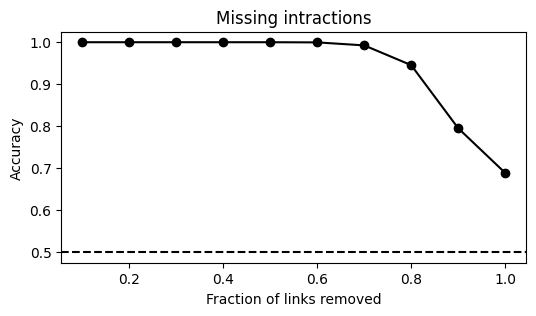

In [472]:
plt.figure(figsize=(6,3))
plt.plot(rat,accs,'-o',color='black')
plt.axhline(y = 0.5, color = 'k', linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Fraction of links removed')
plt.title('Missing intractions')


### Spurious Intercations (Adding Links)

In [473]:
#add links to the adjacency matrix A_T based on a specified ratio
def link_adder(A_T, ratio):
    zero_index = np.where(A_T==0)
    zero_list = [[zero_index[0][i], zero_index[1][i]] for i in range(len(zero_index[0]))]
    r = random.sample(zero_list, int(ratio * np.sum(A_T)/2))
    return(r)

#sorting
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li.reverse()

#extract the first element
#This function is intended to extract the first elements from a list of pairs
def Extract(lst):
    return list(list(zip(*lst))[0])


In [474]:
def acc(k):
    zeros = k.count(0)
    ones = k.count(1)

    if zeros == 0:
        return 0  # Handle the case when there are no zeros (or return another appropriate value)

    ef = 0
    for i in range(len(k)):
        if k[i] == 1:
            ef += k[i:].count(0) / zeros

    return ef / ones

In [475]:
one_real = []
one_index = np.where(A_T==1)#find the indices of one entries in the adjacency matrix

for i in tqdm(range(len(one_index[0]))):
    #computed reliability for each link is appended to the one_real list
    one_real.append(R(one_index[0][i], one_index[1][i], A_T, es))

100%|██████████| 42/42 [00:00<00:00, 1070.14it/s]


In [476]:
rat=np.linspace(0.1,1,10)
accs=[]
for r in rat:
    A_T = np.load('AT.npy')
    selected_links = link_adder(A_T, r)
    for link in selected_links: A_T[link[0], link[1]] = 1
    np.save('A0',A_T)
    one_fake=[]
    for i in selected_links:
        one_fake.append(R(i[0], i[1], A_T, es))
    print('the mean value', round(np.mean(one_fake),2))
    all_real = []
    for i in one_fake: all_real.append([0, i])
    for i in one_real: all_real.append([1, i])
    Sort(all_real)
    ext=Extract(all_real)
    accs.append(acc(ext))

the mean value 7.18
the mean value 7.47
the mean value 7.99
the mean value 8.59
the mean value 9.17
the mean value 9.66
the mean value 10.1
the mean value 10.57
the mean value 11.06
the mean value 11.62


##### conclusion:
the mean values of the reliabilities for added links as we systematically increased the link addition ratio. This information helps us to understand how network reliability changes as we add more links.it appears that as we add more links to the network, the mean reliability of the added links increases. This suggests that adding more links enhances network reliability. The increasing trend in mean reliability indicates that adding more links has a positive impact on the network's reliability.

Text(0.5, 1.0, 'ُSpurious intractions')

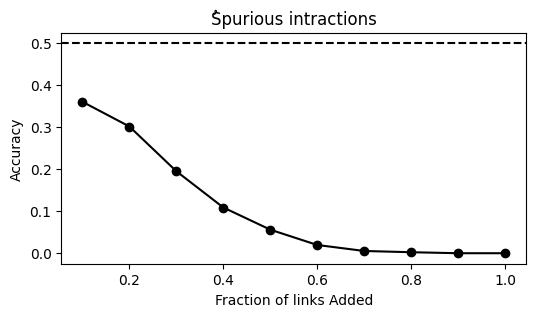

In [477]:
plt.figure(figsize=(6,3))
plt.plot(rat,accs,'-o',color='black')
plt.axhline(y = 0.5, color = 'k', linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Fraction of links Added')
plt.title('ُSpurious intractions')

In [478]:
A_O = np.load('A0.npy')
A_T = np.load('AT.npy')

In [479]:
num_zeros_A_T = (A_T == 0).sum()
print('number of zero in true network',num_zeros_A_T)
num_one_A_T = (A_T == 1).sum()
print('number of one in true network',num_one_A_T)

number of zero in true network 1250
number of one in true network 1250


In [480]:
num_zeros_A_O = (A_O == 0).sum()
print('number of zero in A_O network',num_zeros_A_O)
num_one_A_O = (A_O == 1).sum()
print('number of one in A_O network',num_one_A_O)

number of zero in A_O network 625
number of one in A_O network 1875


In [481]:
# create empty matrix of shape A_O
shape_o=np.shape(A_O)
R_matix=np.zeros(shape_o)
es = Metropolis(100, 20,A_O)

  5%|▌         | 1/20 [00:00<00:03,  5.25it/s]

751.8286065679706
99


 10%|█         | 2/20 [00:00<00:03,  5.14it/s]

759.5478108970153
99


 15%|█▌        | 3/20 [00:00<00:03,  5.28it/s]

769.5239331135286
99


 20%|██        | 4/20 [00:00<00:03,  5.24it/s]

739.1533105264114
99
750.5915232335442

 30%|███       | 6/20 [00:01<00:02,  5.22it/s]


99
742.712344806723
99


 40%|████      | 8/20 [00:01<00:02,  5.00it/s]

731.1312218110991
99
735.4229154544614
99


 50%|█████     | 10/20 [00:01<00:01,  5.21it/s]

739.693000668913
99
767.7350623621315
99


 60%|██████    | 12/20 [00:02<00:01,  5.32it/s]

762.8650916900008
99
754.6924543942961
99


 70%|███████   | 14/20 [00:02<00:01,  5.30it/s]

750.202991917773
99
742.4332771751762
99


 80%|████████  | 16/20 [00:03<00:00,  5.77it/s]

732.5730575365133
99
721.3353768672912
99


 90%|█████████ | 18/20 [00:03<00:00,  5.80it/s]

750.4485082906912
99
737.8382675203733
99


100%|██████████| 20/20 [00:03<00:00,  5.36it/s]

736.6713721446946
99
746.2069134765557
99


In [484]:
for i in range(shape_o[0]):
    for j in range(shape_o[1]):
        R_matix[i][j]= R(i,j, A_O, es)

In [485]:
print(np.max(R_matix))
print(np.min(R_matix))
R_matix

17.8441
6.26876


array([[11.2037 , 16.71901,  8.14268, ..., 15.84475, 13.61212, 16.08214],
       [16.71901,  8.65152, 17.13902, ...,  7.0869 , 15.39058, 12.24167],
       [11.19251, 17.13902,  9.76829, ..., 16.3954 , 14.12917, 16.56845],
       ...,
       [15.84475, 12.67738, 16.3954 , ..., 12.88889, 15.14838, 12.26667],
       [ 8.13983, 15.31916,  8.825  , ..., 14.51331, 14.07576, 14.82045],
       [16.08214,  8.02576, 16.56845, ..., 12.13333, 14.92727,  8.36364]])

In [486]:
A_O[np.where(R_matix > 3)] = 1
A_O[np.where(R_matix < 8)] = 0

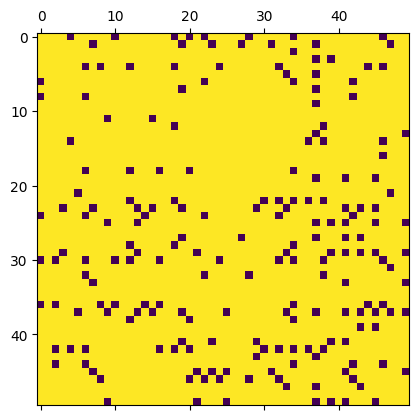

In [487]:
plt.matshow(A_O)

In [488]:
shape_T=np.shape(A_T)
R_mat_A_T=np.zeros(shape_T)
es = Metropolis(100, 20,A_O)

 10%|█         | 2/20 [00:00<00:02,  6.97it/s]

512.9674105290603
99
531.989716972876
99


 20%|██        | 4/20 [00:00<00:02,  6.99it/s]

552.6774101057658
99
565.9902287133473
99


 30%|███       | 6/20 [00:00<00:02,  6.88it/s]

548.0929175955099
99
552.6354100677308
99


 40%|████      | 8/20 [00:01<00:01,  6.98it/s]

528.1015792119175
99
544.7116933851108
99


 50%|█████     | 10/20 [00:01<00:01,  7.01it/s]

550.0684816783822
99
531.0708713949341
99


 60%|██████    | 12/20 [00:01<00:01,  6.69it/s]

565.1535854940131
99
562.1101378847861
99


 70%|███████   | 14/20 [00:02<00:00,  6.44it/s]

578.2377877947891
99
565.5613949926152
99


 80%|████████  | 16/20 [00:02<00:00,  6.72it/s]

554.4402779236059
99
519.6883936498075
99


 90%|█████████ | 18/20 [00:02<00:00,  6.72it/s]

543.8171767979585
99
572.6371157589742
99


100%|██████████| 20/20 [00:02<00:00,  6.75it/s]

570.0276911216264
99
558.5713995886578
99


In [489]:
for i in range(shape_T[0]):
    for j in range(shape_T[1]):
        R_mat_A_T[i][j]= R(i,j, A_T, es)

In [490]:
print(np.max(R_mat_A_T))
print(np.min(R_mat_A_T))
R_mat_A_T

13.94286
5.4899


array([[ 6.8578 , 12.12073,  8.96412, ..., 12.42143,  8.52058, 12.38766],
       [12.12073,  7.03352, 10.50699, ...,  7.1452 , 10.88691,  7.48131],
       [ 8.96412, 10.50699,  7.96717, ..., 11.14113,  8.97042, 10.78625],
       ...,
       [12.42143,  7.1452 , 11.14113, ...,  6.69697, 11.23214,  7.45833],
       [ 8.52058, 10.88691,  8.97042, ..., 11.23214,  6.7807 , 11.9053 ],
       [12.38766,  7.48131, 10.78625, ...,  7.45833, 11.9053 ,  6.55556]])

In [491]:
A_T[np.where(R_mat_A_T > 3)] = 1
A_T[np.where(R_mat_A_T < 8)] = 0

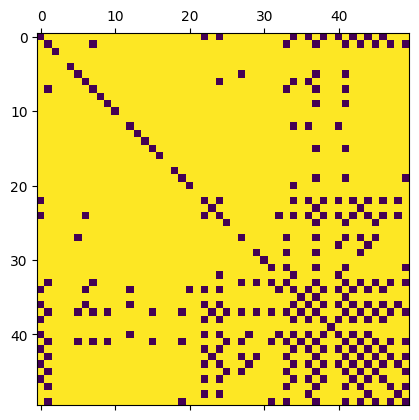

In [492]:
plt.matshow(A_T)